# Inference with CPU, CUDA and TensorRT

### step1: load a pre-trained neural network

In [3]:
import torch
from torchvision import models, transforms

# using cpu
#model = models.resnet50(pretrained=True)

# using gpu
model = models.resnet50(pretrained=True).to("cuda")

/home/gribeiro/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gribeiro/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### step 2: load an example image for predition

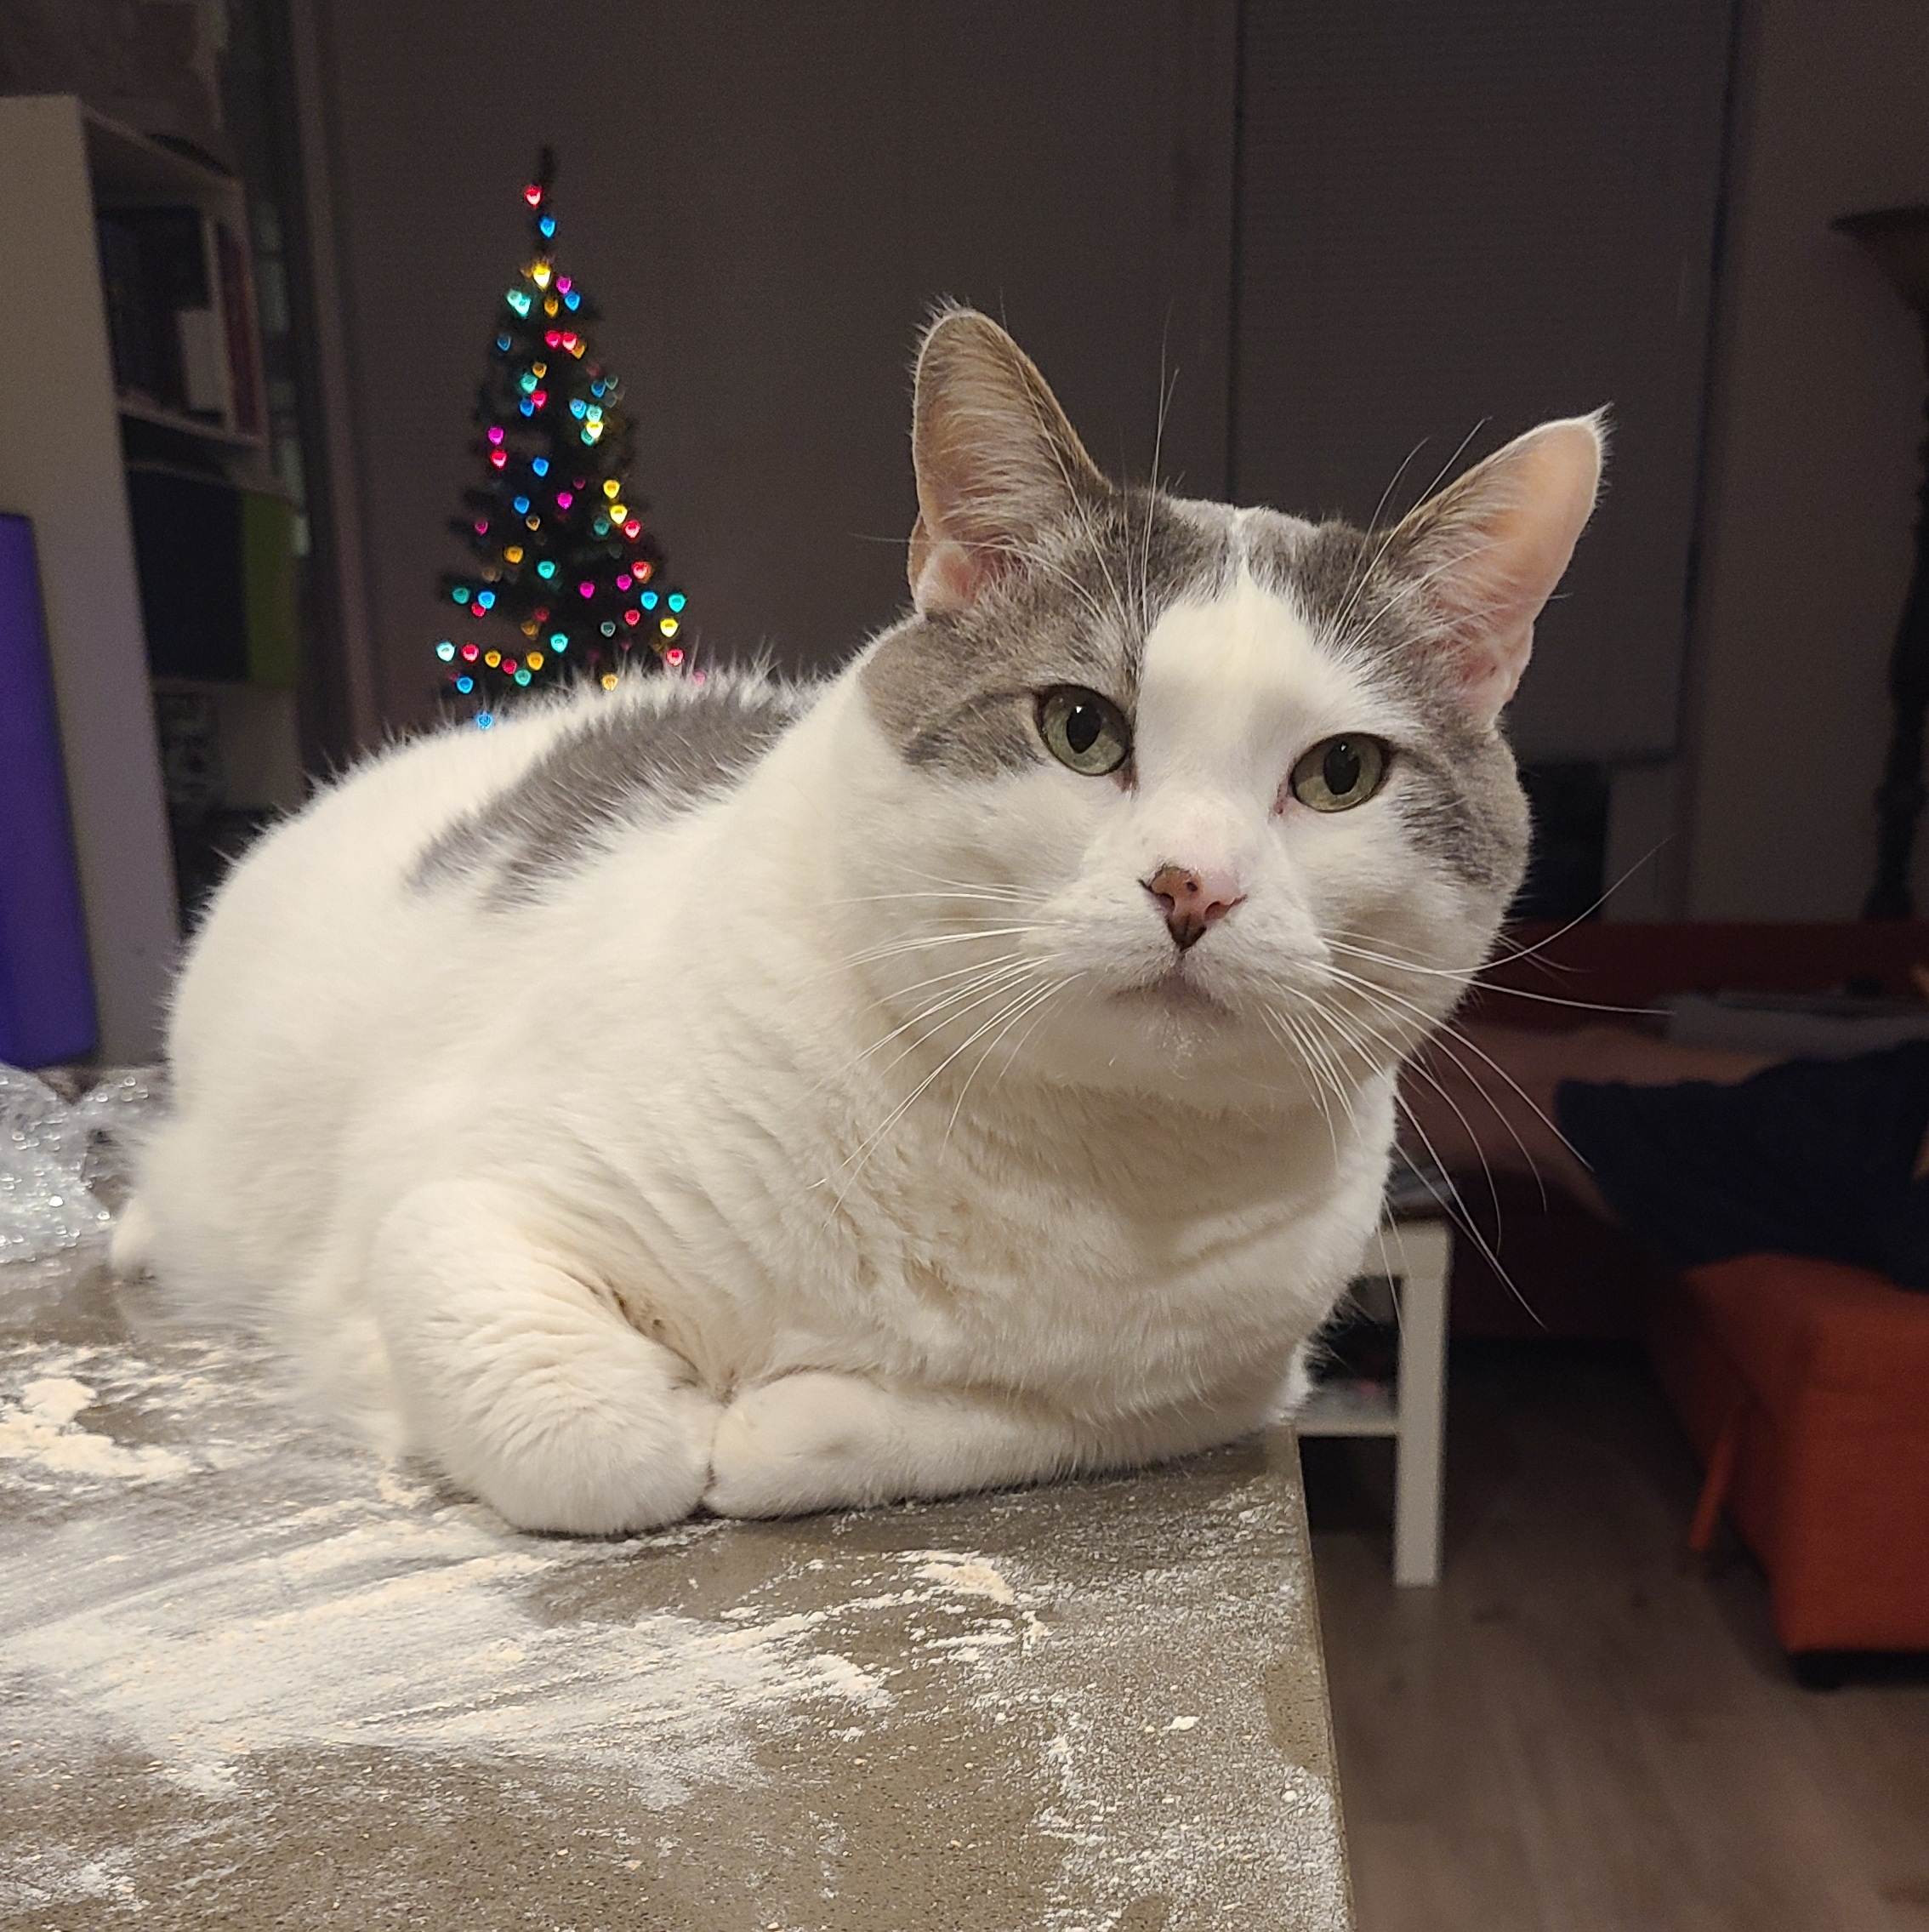

In [4]:
from PIL import Image

img = Image.open("./img1.jpg")
img

### step 3: transform example image (pre-processing)

In [5]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

img = transform(img)
print(img.shape)

torch.Size([3, 224, 224])


### step 4: set a batch size to example image

In [6]:
# using cpu
#img_batch = torch.unsqueeze(img, 0)

#using gpu
img_batch = torch.unsqueeze(img, 0).to("cuda")
img_batch.shape

torch.Size([1, 3, 224, 224])

### step 5: make a prediction and get probabilities for each class

In [7]:
model.eval()
with torch.no_grad():
    outputs = model(img_batch)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

### step 6: get the names of all available ImageNet classes
source: https://github.com/pytorch/hub/blob/master/imagenet_classes.txt

In [9]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [8]:
import pandas as pd

categories = pd.read_csv('https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt', header=None)
categories[0][2]

'great white shark'

### step 7: extract top 5 probabilities and map them to the appropriate class name

In [9]:
topk = 5

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = categories[0][int(classes[i])]
    print("%{} {}".format(int(probability*100), class_label))

%37 Egyptian cat
%19 tabby
%11 tiger cat
%4 Siamese cat
%3 carton


### step 8: define a speed test benchmark function & adjust it

source: ResNet50_example.ipynb
<br>
or: https://github.com/NVIDIA/Torch-TensorRT/blob/master/notebooks/Resnet50-example.ipynb

In [10]:
#copy from TRT
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

def benchmark(model, device="cuda", input_shape=(1, 3, 224, 224), dtype='fp32', nwarmup=50, nruns=100):
    input_data = torch.randn(input_shape)
    input_data = input_data.to(device)
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

### step 9: find out CPU model speed benchmarks

In [29]:
#CPU benchmarks
benchmark(model, device="cpu")

Warm up ...


RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

### step 10: find out CUDA model speed benchmarks

In [11]:
#CUDA benchmarks
model = model.to("cuda")
benchmark(model)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 4.54 ms
Iteration 20/100, ave batch time 4.45 ms
Iteration 30/100, ave batch time 4.45 ms
Iteration 40/100, ave batch time 4.45 ms
Iteration 50/100, ave batch time 4.43 ms
Iteration 60/100, ave batch time 4.42 ms
Iteration 70/100, ave batch time 4.41 ms
Iteration 80/100, ave batch time 4.39 ms
Iteration 90/100, ave batch time 4.38 ms
Iteration 100/100, ave batch time 4.38 ms
Input shape: torch.Size([1, 3, 224, 224])
Output features size: torch.Size([1, 1000])
Average batch time: 4.38 ms


### step 11: trace and compile CUDA model into a TensorRT model

In [12]:
traced_model = torch.jit.trace(model, [torch.randn((1, 3, 224, 224)).to("cuda")])

In [13]:
import torch_tensorrt
import tensorrt

# print(tensorrt.IBuilderConfig.max_workspace_size)

trt_model = torch_tensorrt.compile(
    traced_model,
    inputs = [torch_tensorrt.Input((1, 3, 224, 224), dtype=torch.float32)],
    enabled_precisions = {torch.float32},
    workspace_size=4194304
)

In [34]:
torch.jit.save(trt_model, "teste.pt")

In [35]:
teste = torch.jit.load("teste.pt")

In [17]:
teste3 = torch.jit.load("./models/teste2.trt")

RuntimeError: [Error thrown at core/runtime/TRTEngine.cpp:132] Expected (binding_name == engine_binded_name) to be true but got false
Could not find a TensorRT engine binding for output named output_0


### step 12: find out TensorRT model speed benchmarks

In [36]:
benchmark(teste)

Warm up ...
Start timing ...
Iteration 10/100, ave batch time 2.79 ms
Iteration 20/100, ave batch time 2.79 ms
Iteration 30/100, ave batch time 2.86 ms
Iteration 40/100, ave batch time 2.85 ms
Iteration 50/100, ave batch time 2.77 ms
Iteration 60/100, ave batch time 2.71 ms
Iteration 70/100, ave batch time 2.67 ms
Iteration 80/100, ave batch time 2.64 ms
Iteration 90/100, ave batch time 2.62 ms
Iteration 100/100, ave batch time 2.60 ms
Input shape: torch.Size([1, 3, 224, 224])
Output features size: torch.Size([1, 1000])
Average batch time: 2.60 ms


### step 13: make a prediction with the TensorRT model

In [37]:
trt_model.eval()
with torch.no_grad():
    outputs = trt_model(img_batch)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = categories[0][int(classes[i])]
    print("%{} {}".format(int(probability*100), class_label))

%37 Egyptian cat
%19 tabby
%11 tiger cat
%4 Siamese cat
%3 carton


In [1]:
import torch

x = torch.randn(1024**3, device='cuda')
print(x.shape)

torch.Size([1073741824])


In [5]:
# del x
torch.cuda.empty_cache(),

(None,)

In [29]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  104519 KB |  316058 KB |  314835 MB |  314733 MB |
|       from large pool |   86080 KB |  264896 KB |  307433 MB |  307348 MB |
|       from small pool |   18439 KB |   56314 KB |    7402 MB |    7384 MB |
|---------------------------------------------------------------------------|
| Active memory         |  104519 KB |  316058 KB |  314835 MB |  314733 MB |
|       from large pool |   86080 KB |  264896 KB |  307433 MB |